In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gpytorch
# from voltron.robinhood_utils import GetStockData
import os
import pandas as pd
# import robin_stocks.robinhood as r
import pickle5 as pickle

sns.set_style("whitegrid")
sns.set_palette("bright")

sns.set(font_scale=2.0)
sns.set_style('whitegrid')

import sys
sys.path.append("../")
from botorch.models import SingleTaskGP
from voltron.means import LogLinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel

In [2]:
# with open("../../stock_data.pkl", "rb") as handle:
#     raw_data = pickle.load(handle)
    
with open("./stock_data.pkl", "rb") as handle:
    raw_data = pickle.load(handle)

In [4]:
pd.read_pickle("../../spdr-data/XLE.pkl")

,date,symbol,open_price,close_price,high_price,low_price
0,2016-09-26,XOM,83.52,83.06,84.5000,82.9300
1,2016-09-27,XOM,82.59,83.24,83.3400,82.2900
2,2016-09-28,XOM,83.46,86.90,87.2300,83.3400
3,2016-09-29,XOM,86.97,86.46,87.2000,85.6750
4,2016-09-30,XOM,86.84,87.28,87.8100,86.6500
...,...,...,...,...,...,...
6290,2021-09-17,SLB,28.70,28.31,29.2600,28.0000
6291,2021-09-20,SLB,27.37,27.25,27.7077,26.7050
6292,2021-09-21,SLB,27.61,26.93,27.7800,26.6400
6293,2021-09-22,SLB,27.51,27.15,27.8100,27.1200


In [25]:
np.unique(raw_data["symbol"])

array(['AAPL', 'F', 'JPM', 'SBUX', 'TSLA', 'VIRT'], dtype=object)

# Header

In [26]:
ntest = 200
ntrain = 200
tckrs = ['TSLA', "F", "JPM", "SBUX", 'AAPL', "VIRT"]
tckr = "VIRT"
span = "5year"
interval = 'day'
T = 5.

## Data Setup

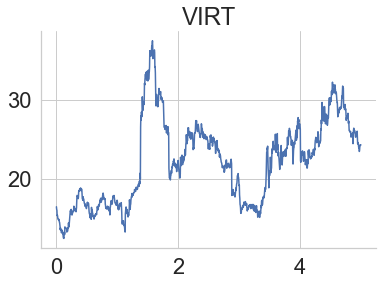

In [27]:
idx = -2
# data = GetStockData(tckr, span=span, interval=interval)
data = raw_data[raw_data["symbol"] == tckr]

ts = torch.linspace(0, T, data.shape[0])
# train_x = ts[:ntrain]
# test_x = ts[ntrain:(ntrain+ntest)]

y = torch.FloatTensor(data['close_price'].to_numpy())
log_returns = torch.log(y[1:]) - torch.log(y[:-1])
# train_y = y[:ntrain]
# test_y = y[ntrain:(ntrain+ntest)]

dt = ts[1] - ts[0]

plt.plot(ts, y)
plt.title(tckr);
sns.despine()
plt.show()

In [28]:
ts.shape

torch.Size([1259])

## Now apply GCPV

In [33]:
def get_and_fit_data_model(train_x, train_y, pred_vol=None, vol_model=None):
    voltron_lh = gpytorch.likelihoods.GaussianLikelihood()
#     voltron = VoltronGP(train_x, train_y.log(), voltron_lh, pred_vol)
    model = SingleTaskGP(train_x.view(-1,1), train_y.log().view(-1,1), likelihood=voltron_lh)
    model.mean_module = gpytorch.means.LinearMean(1)
    model.mean_module = LogLinearMean(1)
    model.mean_module.initialize_from_data(train_x, train_y.log())
    model.likelihood.raw_noise.data = torch.tensor([1e-6])

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(voltron_lh, model)

    for i in range(500):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y.log())
        loss.backward()
        # print(loss.item())
        optimizer.step()
    return model

In [43]:
def predict_prices(test_x, voltron, nvol=10, npx=10):
    ntest = test_x.shape[0]
    # vol_paths = torch.zeros(nvol, ntest)
    px_paths = torch.zeros(npx*nvol, ntest)

    # voltron.vol_model.eval();
    # voltron.eval();

    px_paths = voltron.posterior(test_x).sample(torch.Size(((nvol * npx),))).exp().squeeze(-1)
#     for vidx in range(nvol * npx):
#         vol_pred = voltron.vol_model(test_x).sample().exp()
#         vol_paths[vidx, :] = vol_pred.detach()

#         px_pred = voltron.GeneratePrediction(test_x, vol_pred, npx).exp()
#         px_paths[vidx*npx:(vidx*npx+npx), :] = px_pred.detach().T
    return px_paths

In [44]:
eval_times = list(range(100, ts.shape[0], 100)) #+ [ts.shape[0]]

In [45]:
prob_of_increases = []

for i, time in enumerate(eval_times):
    print("now running time: ", time)
    with gpytorch.settings.max_cholesky_size(2000):
        # pred_vol = get_and_fit_gpcv(ts[:time], log_returns[:(time - 1)])
        # vol_model = get_and_fit_vol_model(ts[:time], pred_vol)
        data_model = get_and_fit_data_model(ts[:time], y[:time], None, None)
        end_ind = -1 if i + 1 >= len(eval_times) else eval_times[i+1]
        paths = predict_prices(ts[time:end_ind], data_model).detach()
        # now we predict the probability of increase at time i + 1
        prob_of_increase = (paths[..., -1] > y[time]).sum() / paths.shape[-2]
        print("prob of stock increase: ", prob_of_increase.detach())

    prob_of_increases.append(prob_of_increase.detach())

now running time:  100
prob of stock increase:  tensor(0.6900)
now running time:  200
prob of stock increase:  tensor(0.8200)
now running time:  300
prob of stock increase:  tensor(0.7900)
now running time:  400
prob of stock increase:  tensor(0.)
now running time:  500
prob of stock increase:  tensor(0.9700)
now running time:  600
prob of stock increase:  tensor(0.7300)
now running time:  700
prob of stock increase:  tensor(0.9600)
now running time:  800
prob of stock increase:  tensor(0.9900)
now running time:  900
prob of stock increase:  tensor(0.4300)
now running time:  1000
prob of stock increase:  tensor(0.2900)
now running time:  1100
prob of stock increase:  tensor(0.3400)
now running time:  1200
prob of stock increase:  tensor(0.4200)


In [68]:
i+1 >= len(eval_times)

True

Text(0, 0.5, 'Prob of Stock Increasing')

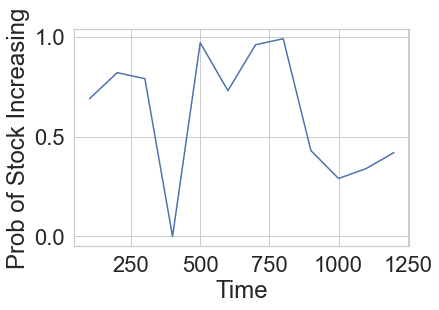

In [69]:
plt.plot(eval_times, prob_of_increases)
plt.xlabel("Time")
plt.ylabel("Prob of Stock Increasing")

In [70]:
torch.save(obj=prob_of_increases, f="matern_v.pt")

In [48]:
from torch.distributions import Beta
from scipy.special import betainc

In [49]:
xs = torch.linspace(0, 1, 100)

In [50]:
prob_incs = torch.tensor(prob_of_increases)

In [51]:
bought_func = lambda xs: betainc(8, 1, xs)
total_held = 1000 * bought_func(prob_incs)[:-1] 

Text(0.5, 0, 'Time')

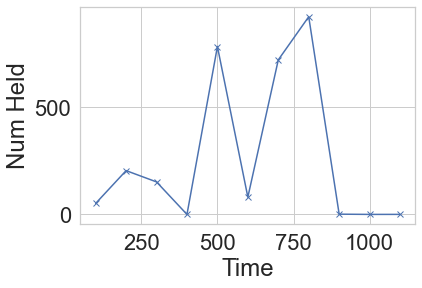

In [52]:
plt.plot(eval_times[:-1], total_held, marker = "x")
plt.ylabel("Num Held")
plt.xlabel("Time")